# Ethereum (ETH) Price Prediction using LSTM

In [1]:
import pandas as pd
import numpy as np
import time
import math
from datetime import date, datetime, timezone, timedelta
import json
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras

## Importing the ETH price data
First the historical ETH prices per day are downloaded from yahoo finance

In [2]:
today = date.today().strftime('%Y-%m-%d')

eth = yf.Ticker('ETH-USD')
eth_data = eth.history(interval='1d', start='2018-01-01' , end=today)
df = eth_data[['Close']] #using the closing price
df = df.rename(columns={'Close': 'Price'})


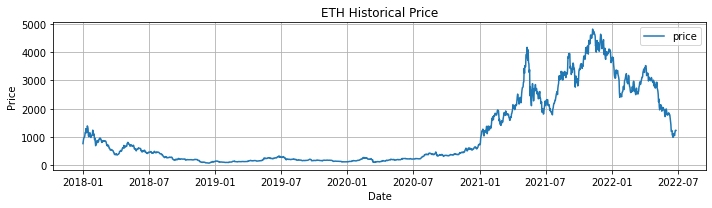

In [3]:
fig, ax = plt.subplots(1, figsize=(10, 3))
sns.lineplot(data=df['Price'], label='price').set(title='ETH Historical Price')
plt.grid(True)
plt.tight_layout()

### Checking stats and nan values

In [4]:
print( f'the are: {df.isna().sum()[0]} nan values in the data frame')

df.describe()

the are: 0 nan values in the data frame


,Price
count,1638.000000
mean,1118.064374
std,1261.925085
min,84.308296
25%,197.635750
50%,407.698105
75%,1944.202911
max,4812.087402


## Selecting the time steps and splitting the dataset
A function, **add_prev_prices** is created to append the previous prices by selecting a time step.

In [5]:
def add_prev_prices(df, time_step = 5):
    df_2 = df.copy()
    steps = []
    for t in range(1,time_step+1):
        shift_t = df_2.shift(t)
        steps.append(shift_t)

    for index,step in enumerate(steps, start=1):
        df_2.insert(index,f"Price {-index}", step, True)
    df_2 = df_2.dropna()
    return df_2

In [6]:
#using the prices of the past week
time_steps = 7
df_shifted = add_prev_prices(df, time_step = time_steps)
df_shifted2 = df_shifted.copy()
df_shifted.head()

,Price,Price -1,Price -2,Price -3,Price -4,Price -5,Price -6,Price -7
Date,,,,,,,,
2018-01-08,1148.530029,1153.170044,1041.680054,997.719971,980.921997,962.719971,884.443970,772.640991
2018-01-09,1299.739990,1148.530029,1153.170044,1041.680054,997.719971,980.921997,962.719971,884.443970
2018-01-10,1255.819946,1299.739990,1148.530029,1153.170044,1041.680054,997.719971,980.921997,962.719971
2018-01-11,1154.930054,1255.819946,1299.739990,1148.530029,1153.170044,1041.680054,997.719971,980.921997
2018-01-12,1273.199951,1154.930054,1255.819946,1299.739990,1148.530029,1153.170044,1041.680054,997.719971


In this case, a time step of **7 days** was selected. This means, that the prices of the last 7 days are appended to the dataset. These historical prices are going to be used for forecasting the ETH price of the day.

In [7]:
#selecting the size of the training set
df_shifted = df_shifted.to_numpy()
print(f'length of the dataset: {len(df_shifted)}') #size of dataframe

training_size = 0.8
print(f'The {training_size:.0%} of the dataset is going to be used for training \n')

len_train = math.floor(len(df_shifted)*training_size) #0.8 traiing
len_valid =  math.floor(len(df_shifted)*(training_size+0.1)) #0.1 validation

#splitting intro training and test set. From the training set we are going to also get the validation set
training_set = df_shifted[:len_valid] 
test_set = df_shifted[len_valid:]

print(f'Length of training set: {len(training_set)}')
print(f'Length of test set: {len(test_set)}')

length of the dataset: 1631
The 80% of the dataset is going to be used for training 

Length of training set: 1467
Length of test set: 164


The dataset was splitted into training and test set. From the training set we are also going to get the validation set that is going to be used for training the neural network.

## Scaling the datasets

In [8]:
scaler = MinMaxScaler()
training_set_scaled = scaler.fit_transform(training_set)
test_set_scaled = scaler.transform(test_set) #we dont know the test set on production so we should scale it with the known data

Splitting into training, validation and test set

In [9]:
X_train, y_train =training_set_scaled[:len_train,1:], training_set_scaled[:len_train,0]
X_val, y_val = training_set_scaled[len_train:len_valid,1:], training_set_scaled[len_train:len_valid,0]
X_test, y_test = test_set_scaled[:,1:], test_set_scaled[:,0]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1304, 7), (163, 7), (164, 7), (1304,), (163,), (164,))

Reshaping the features for having the tensor shape needed as input for the neural network

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1 )
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1 )
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1 )

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1304, 7, 1), (163, 7, 1), (164, 7, 1), (1304,), (163,), (164,))

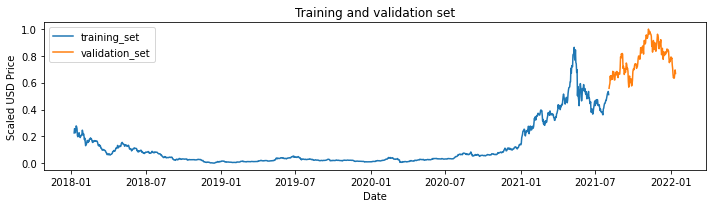

In [11]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.plot(df_shifted2.index[:len_train], y_train, label='training_set')
plt.plot(df_shifted2.index[len_train:len_valid],y_val, label='validation_set')
plt.title('Training and validation set')
plt.xlabel('Date')
plt.ylabel('Scaled USD Price')
ax.legend()
plt.tight_layout()
plt.show()

# LSTM Model

In [27]:
#importing the functions needed from keras 
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras import layers
from keras.metrics import RootMeanSquaredError
from keras.callbacks import ModelCheckpoint

## Model for predicting the price for the next day

In [50]:
model = Sequential()
model.add(layers.InputLayer(input_shape=(None,1)))
model.add(layers.LSTM(32, return_sequences=True, dropout=0.15)) #30
model.add(layers.LSTM(16, return_sequences=False, dropout=0.5)) #20
model.add(keras.layers.Dense(1))

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, None, 32)          4352      
_________________________________________________________________
lstm_11 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________
None


The model is going to be trained using the following parameters:
- Optimizer: Adam
- Learning rate: 0.01
- Loss Function: MSE
- Metrics for validation: RMSE
- epochs: 50

In [51]:
filepath = 'best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
##################################################
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01),metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks = [checkpoint],epochs=50)

Epoch 1/50
36/41 [=========================>....] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0811
Epoch 00001: val_loss improved from inf to 0.02809, saving model to best_model.hdf5
41/41 [==============================] - 1s 20ms/step - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1676
Epoch 2/50
34/41 [=======================>......] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0449
Epoch 00002: val_loss improved from 0.02809 to 0.01111, saving model to best_model.hdf5
41/41 [==============================] - 0s 6ms/step - loss: 0.0020 - root_mean_squared_error: 0.0446 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 3/50
38/41 [==========================>...] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0406
Epoch 00003: val_loss did not improve from 0.01111
41/41 [==============================] - 0s 6ms/step - loss: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 0.0165 - val_root

Epoch 26/50
31/41 [=====================>........] - ETA: 0s - loss: 5.2717e-04 - root_mean_squared_error: 0.0230
Epoch 00026: val_loss improved from 0.00850 to 0.00645, saving model to best_model.hdf5
41/41 [==============================] - 0s 6ms/step - loss: 5.6521e-04 - root_mean_squared_error: 0.0238 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0803
Epoch 27/50
41/41 [==============================] - ETA: 0s - loss: 5.6536e-04 - root_mean_squared_error: 0.0238
Epoch 00027: val_loss did not improve from 0.00645
41/41 [==============================] - 0s 6ms/step - loss: 5.6536e-04 - root_mean_squared_error: 0.0238 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1607
Epoch 28/50
32/41 [======================>.......] - ETA: 0s - loss: 5.9837e-04 - root_mean_squared_error: 0.0245
Epoch 00028: val_loss did not improve from 0.00645
41/41 [==============================] - 0s 5ms/step - loss: 6.0136e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0089 - val_root_mean_s

In the following plot we can see how the training and validation loss changed during the training.

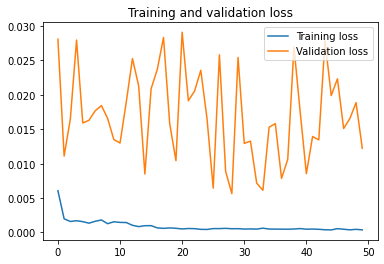

<Figure size 432x288 with 0 Axes>

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.figure()
plt.show()

## Predictions for the next day in the test set

Test Predictions shape: (164, 8)


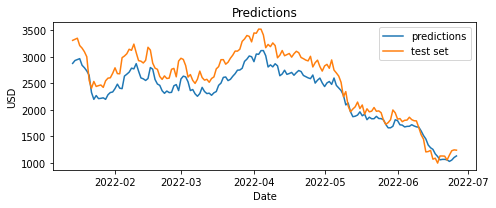

In [53]:
test_predictions = model.predict(X_test)

test_predictions = np.repeat(test_predictions, (time_steps+1), axis = 1) #to have a matrix of the same size of scaler
                                                                                #and then get the first column that is the target 

print(f'Test Predictions shape: {test_predictions.shape}')
test_predictions_scaledback =scaler.inverse_transform(test_predictions)[:,0]


fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(df_shifted2[len_valid:].index,test_predictions_scaledback, label='predictions')
#plt.plot(y_test, label= 'test set')
plt.plot(df_shifted2[len_valid:].index,test_set[:,0], label= 'test set')
ax.legend()
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Predictions')
plt.tight_layout()
plt.show()

In the above plot we can see that the predictions are similar to the prices of the test set. If we want to predict the price of **tomorrow**, we need to consider the ETH price of today plus the last 6 prices:

In [54]:
#predictions for tomorrow
today_price = y_test[-1]
X_today = np.append(today_price,X_test[-1,:-1]).reshape(1,X_test.shape[1],1)
tomorrow_prediction = model.predict(X_today)

tomorrow_predictions = np.repeat(tomorrow_prediction, (time_steps+1), axis = 1) 
tomorrow_predictions_scaledback =scaler.inverse_transform(tomorrow_predictions)[:,0]

print(f'ETH Closing Prediction for tomorrow({date.today() + timedelta(1)}) : ${math.floor(tomorrow_predictions_scaledback[0])} USD')
#prediction 06-25: 1061 USD
#prediction 06-26: 1133 USD

ETH Closing Prediction for tomorrow(2022-06-27) : $1136 USD


## Model for predicting the next 10 days
The previous model is only for forecasting the price of the following day. Now we are going to build a model for forecasting the **following 10 days**.

First the dataset must be adjusted for predicting 10 days for each input

In [33]:
def adjust_datasets(X, y, days_prediction=10):
    new_y = []
    for index in range(len(y)-days_prediction): #+1
        new_y.append(y[index:days_prediction+index])
    new_y = np.array(new_y)
    new_y = new_y.reshape(new_y.shape[0],days_prediction,1) #tensor
    X = X[:new_y.shape[0]]
    return X,new_y

In [34]:
days_prediction = 10

X_train_forecast,y_train_forecast = adjust_datasets(X_train, y_train, days_prediction=days_prediction)
X_val_forecast,y_val_forecast = adjust_datasets(X_val, y_val, days_prediction=days_prediction)
X_test_forecast,y_test_forecast = adjust_datasets(X_test, y_test, days_prediction=days_prediction)

#checking the shapes. must have tensor shape
X_train_forecast.shape, X_val_forecast.shape, X_test_forecast.shape,\
y_train_forecast.shape, y_val_forecast.shape, y_test_forecast.shape

((1294, 7, 1),
 (153, 7, 1),
 (154, 7, 1),
 (1294, 10, 1),
 (153, 10, 1),
 (154, 10, 1))

## LSTM Model 2

In [44]:
model_2 = Sequential()
model_2.add(layers.InputLayer(input_shape=(None,1)))
model_2.add(layers.LSTM(32, return_sequences=True, dropout=0.15)) #30
model_2.add(layers.LSTM(16, return_sequences=False, dropout=0.5)) #20
model_2.add(keras.layers.Dense(days_prediction)) #output of the NN must be the number of days to predict

print(model_2.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, None, 32)          4352      
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                170       
Total params: 7,658
Trainable params: 7,658
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
filepath = 'best_model_10.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
##################################################

model_2.compile(loss='mse', optimizer=Adam(learning_rate=0.01),metrics=[RootMeanSquaredError()])

history = model_2.fit(X_train_forecast, y_train_forecast, validation_data=(X_val_forecast, y_val_forecast),\
                    callbacks = [checkpoint],epochs=50)

Epoch 1/50
34/41 [=======================>......] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.1019
Epoch 00001: val_loss improved from inf to 0.09360, saving model to best_model_10.hdf5
41/41 [==============================] - 1s 19ms/step - loss: 0.0093 - root_mean_squared_error: 0.0966 - val_loss: 0.0936 - val_root_mean_squared_error: 0.3059
Epoch 2/50
35/41 [========================>.....] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0512
Epoch 00002: val_loss improved from 0.09360 to 0.02993, saving model to best_model_10.hdf5
41/41 [==============================] - 0s 6ms/step - loss: 0.0027 - root_mean_squared_error: 0.0515 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1730
Epoch 3/50
39/41 [===========================>..] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0506
Epoch 00003: val_loss did not improve from 0.02993
41/41 [==============================] - 0s 5ms/step - loss: 0.0025 - root_mean_squared_error: 0.0499 - val_loss: 0.0482 - va

38/41 [==========================>...] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0335  
Epoch 00026: val_loss did not improve from 0.02035
41/41 [==============================] - 0s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 0.0450 - val_root_mean_squared_error: 0.2121
Epoch 27/50
39/41 [===========================>..] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0350  
Epoch 00027: val_loss did not improve from 0.02035
41/41 [==============================] - 0s 5ms/step - loss: 0.0012 - root_mean_squared_error: 0.0349 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1883
Epoch 28/50
34/41 [=======================>......] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0329
Epoch 00028: val_loss did not improve from 0.02035
41/41 [==============================] - 0s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1427
Epoch 29/50
36/41 [=========================>...

## Predictions

In [76]:
y_test_forecast[-1].flatten()

array([0.20800938, 0.21198346, 0.19233735, 0.22068463, 0.22068166,
       0.22008564, 0.20455981, 0.22401182, 0.24166451, 0.24517613])

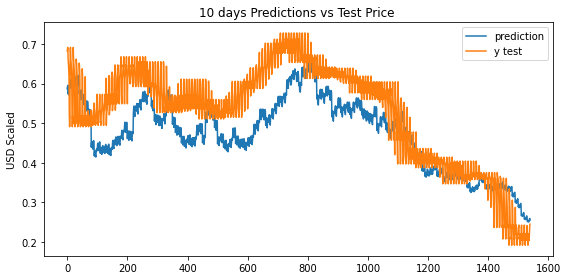

In [85]:
test_predictions_forecast = model_2.predict(X_test_forecast)

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(test_predictions_forecast[:,:].flatten(), label='prediction')
plt.plot(y_test_forecast[:,:].flatten(), label='y test')
plt.ylabel('USD Scaled')
plt.legend(loc='best')
plt.title(f'{days_prediction} days Predictions vs Test Price ')
plt.tight_layout()

In the following plot we are going to observe only the forecast for the **last 10 days**, that is the goal of the model.

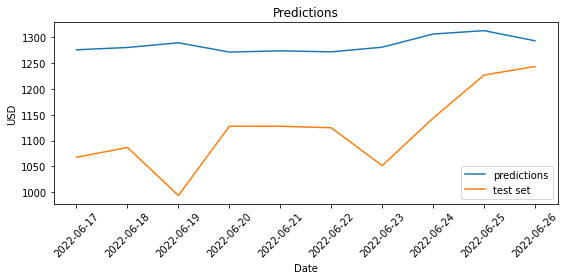

In [86]:
forecast_10_days = test_predictions_forecast[-1].reshape(-1,1) #last 10 days prediction
forecast_10_days = np.repeat(forecast_10_days, (time_steps+1), axis = 1)

forecast_10_days_scaledback =scaler.inverse_transform(forecast_10_days)[:,0]
forecast_10_days_scaledback

y_test_10_days = np.repeat(y_test_forecast[-1], (time_steps+1), axis = 1)
y_test_10_days_scaledback = scaler.inverse_transform(y_test_10_days)[:,0]

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(df_shifted2[-10:].index,forecast_10_days_scaledback, label='predictions')
plt.plot(df_shifted2[-10:].index,y_test_10_days_scaledback, label= 'test set')

ax.legend(loc= 'best')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('USD')
plt.title('Predictions')
plt.tight_layout()
plt.show()

Now we are going to forecast the following 10 days, based on the price of today.

In [87]:
#predictions for tomorrow
today_price = y_test_forecast[-1:,-1].flatten()
X_today = np.append(today_price,X_test_forecast[-1,:-1]).reshape(1,X_test_forecast.shape[1],1)
tomorrow_prediction = model_2.predict(X_today).reshape(-1,1)

forecast_next_10_days = np.repeat(tomorrow_prediction, (time_steps+1), axis = 1) 
forecast_next_10_days_scaledback =scaler.inverse_transform(forecast_next_10_days)[:,0]


In [88]:
for index, price in enumerate(forecast_next_10_days_scaledback, start=1):
    print(f'ETH Forecast for {date.today() + timedelta(index)}: {math.floor(price)} USD')

ETH Forecast for 2022-06-27: 1242 USD
ETH Forecast for 2022-06-28: 1244 USD
ETH Forecast for 2022-06-29: 1254 USD
ETH Forecast for 2022-06-30: 1237 USD
ETH Forecast for 2022-07-01: 1239 USD
ETH Forecast for 2022-07-02: 1237 USD
ETH Forecast for 2022-07-03: 1246 USD
ETH Forecast for 2022-07-04: 1268 USD
ETH Forecast for 2022-07-05: 1275 USD
ETH Forecast for 2022-07-06: 1255 USD
